# Работа с Doc2Vec на примере датасета киноплощадок  

In [56]:
import pandas as pd
import numpy as np
import os
import random
from time import time
import matplotlib.pyplot as plt

import nltk
# nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from gensim.parsing.preprocessing import preprocess_documents
from gensim.parsing.preprocessing import preprocess_string
import gensim.parsing.preprocessing as prep

import re
import gensim
import itertools
from gensim.similarities import MatrixSimilarity
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import namedtuple
from gensim.models import doc2vec

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

import re
import collections
import operator

from gensim.models import TfidfModel
from gensim.similarities import MatrixSimilarity
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.parsing.preprocessing import preprocess_documents
from gensim.parsing.preprocessing import preprocess_string

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.cluster import AffinityPropagation

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

## Датасет

In [2]:
df = list(pd.read_csv('data.csv').descriptions)

print(f'Количество описаний: {len(df)}')
print(f'Количество уникальных: {len(np.unique(df))}')
print(f'Примеры описаний:')
random.sample(df, 10)

Количество описаний: 1884
Количество уникальных: 1580
Примеры описаний:


['Развлекательный детский комплекс, категории: Арбат Ледовые холлы Другие виды спорта',
 'Трехэтажный дом со своей территорией и просторным интерьером.  МО',
 'СПОРТИВНЫЙ ЦЕНТР, категории: Фитнес-клубы Бассейны Войковский',
 'Открытая стоянка в городе, зеленые насаждения, советская архитектура.',
 'СЕРЫЙ ОФИС, категории: Офисы Аэропорт',
 'Зал с белыми стенами и небольшой сценой',
 'Многофункциональный центр для бизнес мероприятий, категории: Конференц-залы Отели, гостиницы, хостелы Концертные залы Алексеевский',
 'ДИЗАЙНЕРСКИЙ ЗАГОРОДНЫЙ ДОМ, категории: Загородные дома и таунхаусы Кунцево',
 'Небольшой концертный зал с баром. В первом ряду расположены столы на 4 человека. Потолок - "звездное небо".',
 'Подземный паркинг , категории: Гаражи и парковки Нагатино-Садовники']

## Препроцессинг данных

In [3]:
descriptions_clear = [x for x in list(pd.read_csv('preprocessed_data.csv').description)]
descriptions = [x for x in list(pd.read_csv('data.csv').descriptions)]

random.sample(descriptions_clear, 15)

['москва',
 'заезд авто',
 'двухуровневый лофт офис большой окно москва',
 'переулок качественный граффити категория улица центральный',
 'темный пространство',
 'поднебесный конюшня категория вид спорт теплый стан открытый площадка загородный дорога',
 'молодежный бар граффити категория ночной клуб бар якиманка',
 'стандартный трешка категория квартира ломоносовский район',
 'москва цао',
 'бизнес центр опен спецмашина кафе зона находиться строительный режим москва',
 'кафе путь категория ресторан кафе соколиный гора',
 'черный бизнес джет москва',
 'высотный жилой комплекс москва состоять шесть корпус собственный яхт-клуб',
 'профессиональный лед категория ледовый холл можайский район',
 'школа барбер категория салон красота частный клиника якиманка мастерская пространство']

## Doc2Vec    
  
  Основные выводы о параметрах из статьи:  
 * dbow (0) favours longer windows for context words than dmpv (1)
 * dmpv also requires more training epochs than dbow. dmpv to reach convergence, the number of epochs is one order of magnitude larger than dbow
 * dbow trains faster and is a better model than dmpv
 * наиболее важным гиперпараметром является порог sample для высокочастотных слов: в наших экспериментах мы обнаружили, что производительность задачи значительно снижается при использовании неоптимального значения
 * попробовать обучать dbow на предобученном word2vec skip-gram
 * With doc2vec the document embedding is clearly biased towards the content words such as tech, costliest and bangalore, and away from the function words. doc2vec learns this from its objective function with negative sampling: high frequency function words are likely to be selected as negative samples, and so the document embedding will tend to align itself with lower frequency content words.
 * для подбора параметров в любом случае нужна какая-то разметка данных. Пока что есть идея разметить по 5тибальной системе схожесть описаний. Это можно сделать вручную, что будет ооочень долго и трудозатратно и нерепрезентативно. Можно запустить краудсорсинг, где попарно будет предложено оценить по 5тибальной шкале схожесть описаний, а затем усреднить результаты. Разметив хотя бы половину-треть данных (500-700 описаний) мы уже получим обучение с учителем. К обучению можно также прикладывать картинки описаний.  
 * кажется, что параметр sample поможет улучшить модель относительно частоты слов. В нашем датасете есть предложения с повторяющейся частью "...категории: " и "...для съемки кино, сериалов...". Данные части предложения не несут смысла для задачи семантической близости слов, поэтому должны игнорироваться и не восприниматься как критерий близости описаний. Это нужно учесть  

Описание параметров Doc2Vec:  
  
* **documents** (итерируемый список помеченных документов, опционально) - входной корпус может быть просто списком элементов, Если documents или corpus_file пусты, модель остается неинициализированной – необходимо будет инициализровать модель другим способом  
* **corpus_file** (строка, опционально) - путь к файлу корпуса. Использовать вместое documents, чтобы повысить производительность. Необходимо передать только один из аргументов document или corpus_file (или ни один из них, в этом случае модель остается неинициализированной). Теги документов присваиваются автоматически и равны номеру строки, как в TaggedLineDocument.  
* **dm** - определяет алгоритм, который будет использоваться. Если dm=1, то используется PV-DM, иначе - PV-DBOW. DBOW работает аналогично skip-gram Word2Vec, за исключением того, что ввод заменяется на токен, прдеставляющий документ. Порядок слов игнорируется. PV-DM работает аналогично CBOW Word2Vec, но добавляет специальный маркер документа к целевым словам и векторы не суммируются, а объединяются. Предсказывает также слово по контексту и токену документа.   
* **vector_size** - размерность будущего вектора предложения  
* **window** - максимальное расстояние между текущим и прогнозируемым словом в предложении  
* **hs** - если установлено значение 1, то используется hierarchical softmax для обучения; если установлено значение 0, and * **negative** ненулевой, то используется negative sampling    
* **min_count** - игнорирует все слова с общей частотой ниже этой  
* **epochs** - rоличество итераций (эпох) по корпусу    
* **dbow_words** - если установлено значение 1, обучаются векторы слов (используя skip-gram) одновременно с обучением векторов документов DBOW; если 0, обучаются только векторы документа (быстрее).
* **sample** - пороговое значение для настройки того, какие часто встречающиеся слова случайным образом downsampled, хорошее значение в диапазоне (0, 1e-5).

In [18]:
# Максимальная длина описания: 766 
# Средняя длина описаний: 60
# Минимальная длина описаний: 5

tagged_docs = [TaggedDocument(d, [i]) for i, d in enumerate(descriptions_clear)]

model = Doc2Vec(tagged_docs,
                dm=0, 
                vector_size=100, 
                window=20, 
                hs=1,
                min_count=1, 
                epochs=10, 
                dbow_words=1,
                sample=0.002,) # [0.00001, 0]

In [19]:
model.build_vocab(tagged_docs)
model.train(tagged_docs,
            total_examples=model.corpus_count,
            epochs=model.epochs)

In [21]:
for k in range(20):
    i =  random.choice(range(len(descriptions)))
    print(f'Предложение:\n\t{descriptions[i]}\nНаиболчее близкие к нему:')
    most_similar = model.dv.most_similar([model.infer_vector(descriptions_clear[i].split())])[:5]
    for j in most_similar:
        print(f'\t{descriptions[j[0]]}')
    print()

Предложение:
	Музей в классическом стиле в золотых оттенках .  Москва
Наиболчее близкие к нему:
	хижина чернил, категории: Салоны красоты и частные клиники ПРОСТРАНСТВА Печатники
	Светлый салон красоты, категории: Общественные учреждения Салоны красоты и частные клиники Академический район
	Открытая парковка на крыше в городской среде, панорамный вид города, металлические ограждения, строения из кирпича.
	Спорт центр для детей, категории: Частные учебные заведения Гимнастические залы, манежы и стадионы Даниловский район
	Ногтевая студия, категории: Салоны красоты и частные клиники Бирюлёво Восточное

Предложение:
	Светлая библиотека с большими окнами.
Наиболчее близкие к нему:
	Кафе в стиле лофт, категории: Рестораны и кафе Тверской
	Офис креативного агенства , категории: Офисы Конференц-залы
	Офис-контора, категории: Офисы Кабинеты, переговорные Тропарёво-Никулино
	Офис лофт с библиотекой, категории: Офисы Якиманка
	Буржуазный офис-лофт, категории: Офисы Красносельский

Предложение:
	

Попробуем убрать некоторые часто встречающиеся фразы, которые не несут для обучения модели смысла. Например, слово "категория" или "проведение съемки кино и теле проектов"


In [10]:
extra_phrases = ["категория", "съемка кино сериал реклама клип",
                 "проведение съемка кино тело проект", "предлагать", 'съемка кино реклама сериал клип']
descriptions_clear_new = descriptions_clear.copy()
for i in range(len(descriptions_clear)):
    for word in extra_phrases:
        descriptions_clear_new[i] = descriptions_clear_new[i].replace(word, '')
    

In [9]:
   
tagged_docs = [TaggedDocument(d, [i]) for i, d in enumerate(descriptions_clear_new)]

model = Doc2Vec(tagged_docs,
                dm=0, 
                vector_size=100, 
                window=20, 
                hs=1,
                min_count=1, 
                epochs=10, 
                dbow_words=1,
                sample=0.002,) # [0.00001, 0]

model.build_vocab(tagged_docs)
model.train(tagged_docs,
            total_examples=model.corpus_count,
            epochs=model.epochs)

for k in range(20):
    i =  random.choice(range(len(descriptions)))
    print(f'Предложение:\n\t{descriptions[i]}\nНаиболее близкие к нему:')
    for j in model.dv.most_similar(i)[:3]:
        print(f'\t{descriptions[j[0]]}')
    print()


KeyboardInterrupt: 

In [ ]:
# model.save('doc2vec')
# model_saved = Doc2Vec.load('doc2vec') 

## Категориальная рек.система
**категории из самых часто встречающихся существительных**  
Попробуем выделить теги для будущих категорий объектов (ChipsSelect)

In [11]:
# def generate_vocabulary(train_captions):
#     word_count = collections.Counter()

#     for current_sentence in train_captions:
#         split_str = (x.lower() for x in re.split('\W+', str(current_sentence).strip()) if x)
#         word_count.update(split_str)
#     return {key: value for (key, value) in word_count.items() if value >= 5}

# ms = Mystem()
# buf = {}
# vocab  = generate_vocabulary(descriptions_clear)
# for key in vocab:
#     if 50 < vocab[key] < 1000 and ms.analyze(key)[0]['analysis'][0]['gr'][0] == 'S':
#         buf[key] = vocab[key]

# print(f'Категории для функционала ChipsSelect:')
# print(list(buf.keys()))

In [12]:
chipselect_freq = ['вид', 'площадка', 'самолет', 'аэропорт', 'конструкция', 'помещение', 'площадь', 'ангар', 
                   'бизнес', 'салон', 'зал', 'офис', 'парковка', 'крыша', 'кафе', 'интерьер', 'дом', 'центр', 
                   'комплекс', 'клуб', 'квартира', 'студия', 'парк', 'лофт', 'ресторан', 'бар', 'клиника', 'тц',
                   'магазин', 'мастерская', 'таунхаус']

**категории из описаний с частью "...каетгории:..."**  
В одном из датасетов встречается формулировка "...категории:..." и далее перечисляются категории, к которым данный объект относитя. Попробуем вычленить из них имеющиеся категории и на основе этого построить рекомендательную систему 

In [13]:
# categories = [x[(x.find('категория') + len('категория') + 1):] for x in descriptions_clear if 'категория' in x]
# buf = {}
# vocab = generate_vocabulary(categories)
# for key in vocab:
#     if ms.analyze(key)[0]['analysis'] != [] and ms.analyze(key)[0]['analysis'][0]['gr'][0] == 'S':
#         buf[key] = vocab[key]

# print(f'Категории для функционала ChipsSelect:')
# print(list(buf.keys()))

In [14]:
chipselect_cat = ['учреждение', 'бассейн', 'баня', 'сауна', 'футбол', 'баскетболла', 'волейболла', 'теннис', 
                  'зала', 'манежы', 'стадион', 'вид', 'спорт', 'бокс', 'борьба', 'фитнес', 'клуб', 'отель', 
                  'гостиница', 'хостел', 'район', 'квартира', 'ресторан', 'кафе', 'арбат', 'холл', 'супермаркет', 
                  'рынок', 'парк', 'пространство', 'площадка', 'салон', 'красота', 'клиника', 'тц', 'магазин', 'офис', 
                  'библиотека', 'промзона', 'площадь', 'крыша', 'кабинет', 'комплекс', 'подъезд', 'подвал', 'здание', 
                  'мастерская', 'студия', 'марьин', 'роща', 'кинотеатр', 'дом', 'таунхаус', 'театр', 'школа', 'автосервис',
                  'автотрасса', 'усадьба', 'гараж', 'парковка', 'аэропорт', 'бар', 'гора', 'конференц', 'зал', 'поселок', 
                  'озеро', 'река', 'кладбище', 'церковь', 'бизнес', 'квартал', 'центр', 'университет', 'больница', 
                  'набережная', 'пляж', 'люблино', 'печатник', 'лаборатория',  'арт', 'галерея','дорога']

Используем данные категории как таргет для Doc2Vec  

In [15]:
data = pd.DataFrame(descriptions_clear_new, columns=['desc'])
data['target'] = list(['']*len(descriptions_clear_new))
for i in range(data.shape[0]):
    words = data.desc[i].split()
    in_list = [x for x in words if x in chipselect_cat+chipselect_freq]
    if len(in_list) != 0:
        data.loc[i, 'target'] = in_list[0]
        
data = data[data.target != '']
data.head()

,desc,target
0,школа бортпроводник общий вид площадка объект ...,школа
1,аэропорт просторный внутренний пространство эс...,аэропорт
2,аэропорт большой внутренний объем помещение ко...,аэропорт
3,ангар стоянка бизнес джет,ангар
4,ангар самолет вертолет,ангар


**поиск параметров через валидацию модели**

In [43]:
def evaluation_doc2vec(dataList, params, processed_corpus, top=10):
    # preprocess corpus
    tagged_corpus = [TaggedDocument(d, [i]) for i, d in enumerate(processed_corpus)]
    
    # preprocess the test dataset
    for movie in dataList:
        movie['desc_preproc'] = preprocess_string(movie['desc'])
        movie['regex'] = movie['titleRegex']
        
    scoreList = []
    
    for param in params:
        param['score'] = 0
        model = None
        try:
            model = Doc2Vec(tagged_corpus,
                            dm=1, 
                            vector_size=param['vector_size'], 
                            window=param['window'], 
                            min_count=1, 
                            epochs=10, 
                            hs=1,
                            sample = param['sample'])

            for movie in dataList:                
                new_doc = movie['desc_preproc']
                test_doc_vector = model.infer_vector(new_doc)
                sims = model.dv.most_similar(positive=[test_doc_vector])
                topSims = sims[:10]
                for i in range(len(topSims)):
                    if movie['regex'] == data['target'].iloc[topSims[i][0]]:
                        param['score'] = param['score'] + (top - i)
            scoreList.append(param)
        except Exception as error:
            print(f'Cannot evaluate model with parameters {param} because of error: {error}')
            continue
    return scoreList

In [118]:
placeVal = [
    {'desc': 'небольшой уютный лестничный клетка старый доходный дом',
     'titleRegex': 'дом'},
    {'desc': 'аэропорт просторный внутренний пространство эскалатор металлический конструкция перекрытие',
     'titleRegex': 'аэропорт'},
    {'desc': 'подземный паркинг гараж парковка нагатино садовник',
     'titleRegex': 'гараж'},
    {'desc': 'номер шикарный ванный  отель гостиница хостел басманныйл',
     'titleRegex': 'отель'},
    {'desc': "двухуровневый лофт офис большой окно",
     'titleRegex': 'лофт'},
    {'desc': 'небольшой уютный лестничный клетка старый доходный дом',
     'titleRegex': 'дом'},
    {'desc':'современный школа фасад белый цвет цветной вставка территория современный спортивный площадка футбольный поле химки',
    'titleRegex':'школа'},
    {'desc':'небольшой гаражно-строительный кооператив  замоскворечье автосервис автотрасса',
    'titleRegex':'автосервис'},
    {'desc':'большой открытый парковка возле торговый центр зеленый насаждение',
    'titleRegex':'парковка'},
    {'desc':'офис опен спейс белый стена большой окно вид старый окно большой лифт зона ресепшено москва',
    'titleRegex':'офис'}
   ]

# sample = [0, 0.1, 0.01, 0.001, 0.0001, 0.00001]
# vector_size = [10, 20, 50, 70, 100, 150, 200]
# window = [1, 2, 3, 5, 7, 10]

sample = [0.075, 0.070, 0.065, 0.050, 0.030, 0.025, 0.01]
vector_size = [70, 100, 125, 150, 175, 200]
window = [3,5,7]

paramsList = [{'sample' : item[0],
               'vector_size': item[1],
               'window': item[2]} for item in
                 list(itertools.product(*[sample,
                                          vector_size,
                                          window]))]

processed_corpus = [x.split() for x in data.desc]

In [119]:
score_doc2vec = evaluation_doc2vec(placeVal, paramsList, processed_corpus)
score_doc2vec = pd.DataFrame(score_doc2vec)
score_doc2vec = score_doc2vec.sort_values(by=['score'],
                                          ascending=False)
print(score_doc2vec.head(15))

# sample  vector_size  window  score
# 0.025          200       7    225
# 0.070          200       7    218
# 0.030          125       5    218

# 0.1          70          7    225
# 0.01         70          7    223
# 0.1          200         7    219

# .050         125          7   229
# .075         100          7   221
# .025         70           7   221
# .075         70           7   221
# .075         150          7   220
# .010         70           5   219

    sample  vector_size  window  score
71   0.025          200       7    225
23   0.070          200       7    218
52   0.030          125       5    218
56   0.030          175       5    217
30   0.065          150       5    217
66   0.025          150       5    216
36   0.050           70       5    216
24   0.065           70       5    214
21   0.070          175       7    214
29   0.065          125       7    213
38   0.050          100       5    212
32   0.065          175       5    212
13   0.070           70       7    212
25   0.065           70       7    212
61   0.025           70       7    211


In [126]:
sample = 0.025
vector_size = 200
window = 7

processed_corpus = [x.split() for x in descriptions_clear_new]
tagged_corpus = [TaggedDocument(d, [i]) for i, d in enumerate(processed_corpus)]
model = Doc2Vec(tagged_corpus,
                dm=0, 
                vector_size=vector_size, 
                window=window, 
                min_count=1, 
                epochs=10, 
                hs=1,
                dbow_words=0,
                sample = sample)

model.build_vocab(tagged_corpus)
model.train(tagged_corpus,
            total_examples=model.corpus_count,
            epochs=model.epochs)

In [127]:
for k in range(20):
    i =  random.choice(range(len(descriptions)))
    print(f'Предложение:\n\t{descriptions[i]}\nНаиболчее близкие к нему:')
    most_similar = model.dv.most_similar([model.infer_vector(descriptions_clear_new[i].split())])[:5]
    for j in most_similar:
        print(f'\t{descriptions[j[0]]}')
    print()

Предложение:
	Ресторан ковер-самолет, категории: Рестораны и кафе Очаково-Матвеевское
Наиболчее близкие к нему:
	Ресторан ковер-самолет, категории: Рестораны и кафе Очаково-Матвеевское
	Ресторан с карпами кои, категории: Рестораны и кафе Мещанский
	Кафе в шалаше, категории: Рестораны и кафе Мещанский
	Ресторан подсвечник, категории: Рестораны и кафе Кунцево
	обед в бетоне, категории: Рестораны и кафе Ночные клубы и бары Тверской

Предложение:
	На территории академии располагаются корпуса XVIII и XX веков. Внутри корпуса отреставрированы.
Наиболчее близкие к нему:
	На территории академии располагаются корпуса XVIII и XX веков. Внутри корпуса отреставрированы.
	Дизайн интерьера бизнес центра исполнен в современном стиле хай-тек. Основной особенностью здания является два последних VIP этажа (13-14) с просторными террасами, отдельными лифтами и свободной планировкой. Среди объектов инфраструктуры бизнес центра  следует отметить: столовую для сотрудников, фитнес клуб с бассейном, парковка с

In [16]:
# model.save('doc2vec with parametrs')
model = Doc2Vec.load('doc2vec with parametrs') 

*Проблема 1:* Для одного предложения и в том, и в другом случае может быть несколько таргетов. В целом можно выбрать любой из предложенных, а лучше самый первый, так как владельцы вносят наиболее значимую информацию первоочередно и так повышаются шансы нашего "GridSearchCV" точнее подобрать параметры.

*Проблема 2:* категории ограничивают наши кластеры. Модель будет предсказывать только по ним, кластеры получатся большие, объединенные скорее тегом, чем описанием.

*Проблема 3:* категории может не быть. Если у нас появится новое описание, непохожее на предыдущие (а такое может произойти даже при обучении, если выбрать методику только слова после "категория:") оно с малой вероятностью подойдет к одному из предложенных кластеров. 

## Кластеризация  
Можем остановиться на этом моменте и сделать рекомендательную систему, которая будет предлагать выбрать что-то из значений таргета и выдавать все возможные варианты по этому таргету пользователю. ChipsSelect выбор для пользователя  
**СДЕЛАТЬ ИНТЕРФЕЙС, ГДЕ ЕСТЬ ВЫБОР TARGET, А ЗАТЕМ ВЫДАЧА ВСЕХ ПРЕДЛОЖЕНИЙ ПО ЭТОМУ ТЭГУ**  
Можем сделать рекомендательную систему на основе результатов Doc2Vec модели, выдавая 10-20 наиболее ближайших  
Мы пойдем дальше и кластеризируем наши вектора текстов.

In [28]:
# vectors = pd.DataFrame([model.infer_vector(x.split()) for x in descriptions_clear_new])

# time_start = time()
# tsne = TSNE(n_components=2,
#             perplexity=25,
#             learning_rate = 500,
#             init='random')

# tsne_res = tsne.fit_transform(vectors)
# print('TSNE done! Time elapsed: {} seconds'.format(time()-time_start))
# print(tsne_res[:,0])
# df_picture = pd.DataFrame({'desc':descriptions,
#                            'tsne_x':tsne_res[:,0], 
#                            'tsne_y':tsne_res[:,1],
#                            'desc_clear':descriptions_clear_new,
#                            'target':list(['']*len(descriptions_clear_new))})

# for i in range(df_picture.shape[0]):
#     words = df_picture.desc_clear[i].split()
#     in_list = [x for x in words if x in chipselect_cat + chipselect_freq]
#     if len(in_list) != 0:
#         df_picture.loc[i, 'target'] = in_list[0]
# df_picture.target = df_picture.target.replace('', 'none')
# df_picture['target_num'] =  LabelEncoder().fit_transform(df_picture.target)

TSNE done! Time elapsed: 6.381903886795044 seconds
[ 29.325033 -71.643585 -53.53884  ...  22.165121  26.64955   27.260075]


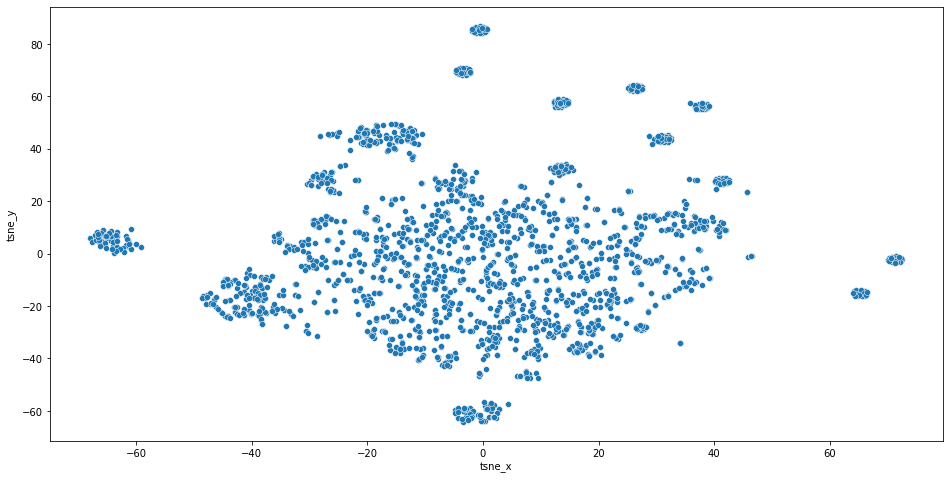

In [34]:
# i = 2
# df_picture = pd.read_csv(f'TSNE results {i}.csv')

# # uni = list(set(df_picture.target_num.unique()))
# # palette = [plt.cm.jet(float(l)/max(uni)) for l in uni]

# plt.figure(figsize=(16,8))
# sns.scatterplot(x="tsne_x", y="tsne_y",
#                 data=df_picture,
# #                 alpha=0.8,
# #                 hue='target',
# #                 palette=palette
#                )
# plt.show()

In [30]:
# df_picture.to_csv('TSNE results 3.csv', index=False)
# df_picture = pd.read_csv('TSNE results 3.csv')

<AxesSubplot:xlabel='tsne_x', ylabel='tsne_y'>

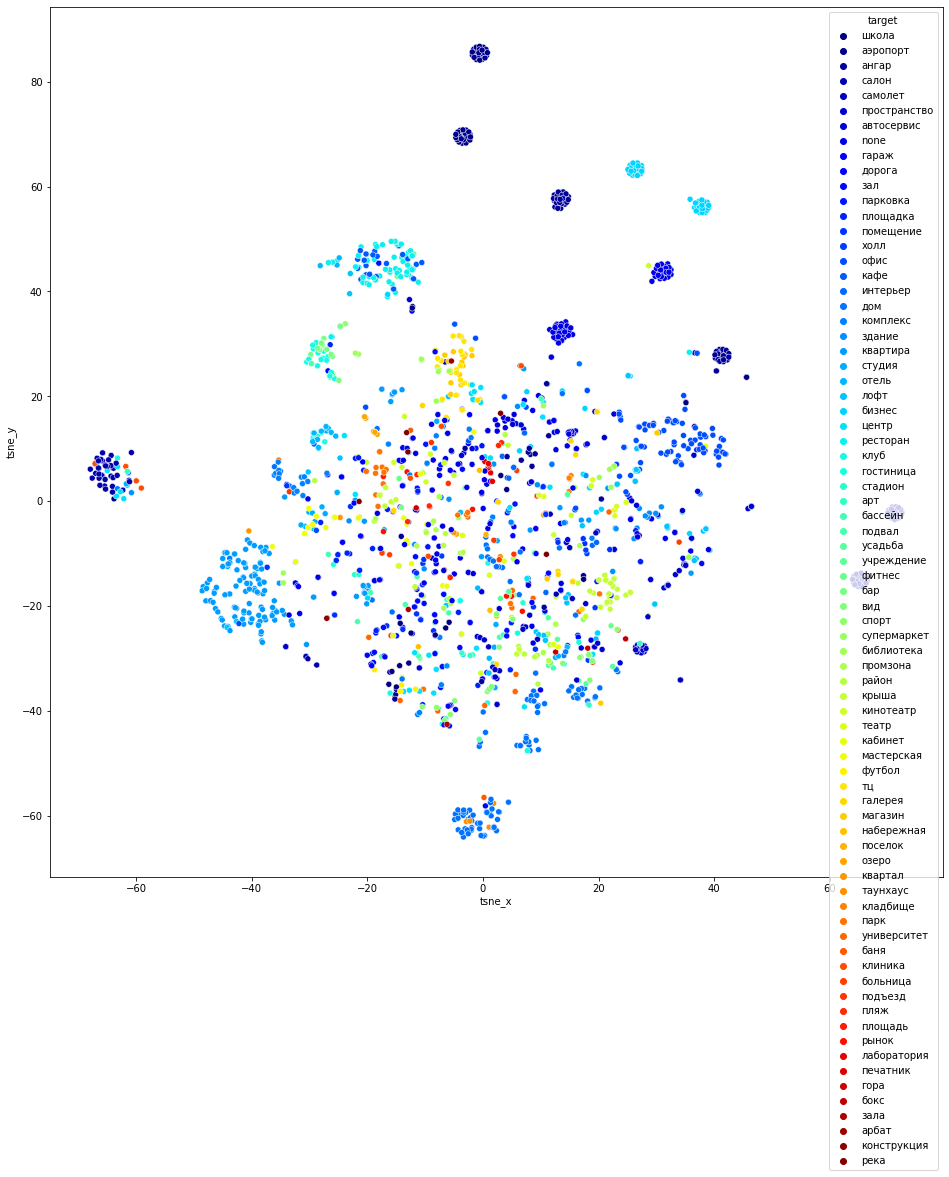

In [48]:
# # kmeans = KMeans(n_clusters=100,
# #                 n_init=20,
# #                 init='random',
# #                 random_state=42).fit(vectors)

# df_picture['labels_kmeans'] = kmeans.labels_

# # uni = list(set(df_picture.target_num.unique()))
# uni = list(set(df_picture.labels_kmeans.unique()))
# palette = [plt.cm.jet(float(l)/max(uni)) for l in uni]

# plt.figure(figsize=(16,16))
# sns.scatterplot(x="tsne_x", y="tsne_y",
#                 data=df_picture,
#                 alpha=1,
# #                 hue='target',
#                 hue='labels_kmeans',
#                 palette=palette
#                )


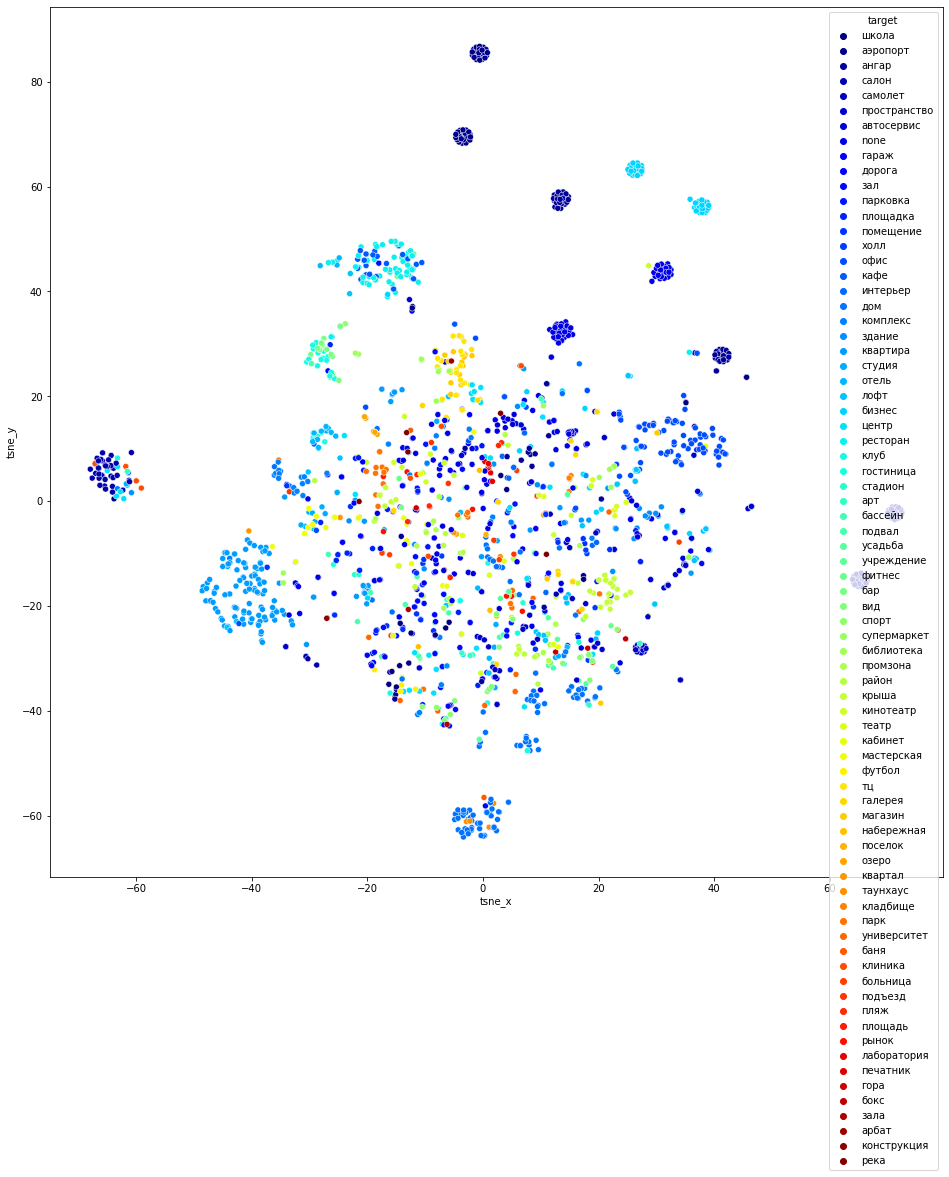

In [47]:
# affinity_prop = AffinityPropagation(damping = 0.9,
#                                     convergence_iter=13,
#                                     random_state=42).fit(vectors)

# df_picture['labels_affinity_prop'] = affinity_prop.labels_

# # uni = list(set(df_picture.target_num.unique()))
# uni = list(set(df_picture.labels_affinity_prop.unique()))
# palette = [plt.cm.jet(float(l)/max(uni)) for l in uni]

# plt.figure(figsize=(16,16))
# sns.scatterplot(x="tsne_x", y="tsne_y",
#                 data=df_picture,
#                 alpha=1,
# #                 hue='target',
#                 hue='labels_affinity_prop',
#                 palette=palette
#                )
# plt.show()

In [52]:
clusters = df_picture.labels_affinity_prop.unique()
for i in clusters:
    buf = df_picture[df_picture['labels_affinity_prop'] == i].desc
    print(f'РАЗМЕР КЛАСТЕРА: {buf.shape[0]}')
    buf = buf.drop_duplicates()
    print(f'УНИКАЛЬНЫХ ПРЕДЛОЖЕНИЙ: {buf.shape[0]}')
    for j in buf:
        print(j)
    print()

РАЗМЕР КЛАСТЕРА: 3
УНИКАЛЬНЫХ ПРЕДЛОЖЕНИЙ: 2
Школа Бортпроводников, общий вид площадок, объектов , самолетов. Зеленые насаждения.
Школа Бортпроводников, общий вид площадок, объектов , самолетов. Зеленые насаждения. Test

РАЗМЕР КЛАСТЕРА: 23
УНИКАЛЬНЫХ ПРЕДЛОЖЕНИЙ: 2
Аэропорт, просторные внутренние пространства, эскалатор, металлические конструкции перекрытия.
  Аэропорт, просторные внутренние пространства, эскалатор, металлические конструкции перекрытия.

РАЗМЕР КЛАСТЕРА: 23
УНИКАЛЬНЫХ ПРЕДЛОЖЕНИЙ: 2
Аэропорт, большие внутренние объемы помещений, колонны, большие площади остекления, открытые металлические конструкции.
  Аэропорт, большие внутренние объемы помещений, колонны, большие площади остекления, открытые металлические конструкции.

РАЗМЕР КЛАСТЕРА: 26
УНИКАЛЬНЫХ ПРЕДЛОЖЕНИЙ: 5
Ангар для стоянки бизнес-джетов.
  Ангар для стоянки бизнес-джетов.  Москва\t\t\t\t\t\t\t\t  \t\t\t\t\t\t\t\t
Ангар для стоянки бизнес-джетов.  Москва
Ангар с гримерной комнатой.  Москва
елезобетонный ост 

In [55]:
df_picture.to_csv('clustered data.csv', index=False)
df_picture = pd.read_csv('clustered data.csv')

  Ссылки на источники:  
[Препроцессинг русского текста](https://www.kaggle.com/alxmamaev/how-to-easy-preprocess-russian-text)  
[Tf-idf and doc2vec hyperparameters tuning](https://medium.com/betacom/hyperparameters-tuning-tf-idf-and-doc2vec-models-73dd418b4d)  
[A simple explanation of document embeddings generated using Doc2Vec](https://medium.com/@amarbudhiraja/understanding-document-embeddings-of-doc2vec-bfe7237a26da)  
[Doc2vec paragraph embeddings](https://radimrehurek.com/gensim/models/doc2vec.html)  
[An Empirical Evaluation of doc2vec with Practical Insights into Document Embedding Generation](https://arxiv.org/pdf/1607.05368.pdf)  
[Robust Word2Vec Models with Gensim](https://www.kdnuggets.com/2018/04/robust-word2vec-models-gensim.html)  
[Интерактивное управление в Jupyter Notebooks](https://medium.com/nuances-of-programming/%D0%B8%D0%BD%D1%82%D0%B5%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D0%B5-%D1%83%D0%BF%D1%80%D0%B0%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5-%D0%B2-jupyter-notebooks-4fd1fccb5788)

Статьи на которые еще нужно обратить внимание:  
[Doc2Vec-поиск сходства документов в тестовых данных](https://coderoad.ru/55924378/Doc2Vec-%D0%BF%D0%BE%D0%B8%D1%81%D0%BA-%D1%81%D1%85%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%B0-%D0%B4%D0%BE%D0%BA%D1%83%D0%BC%D0%B5%D0%BD%D1%82%D0%BE%D0%B2-%D0%B2-%D1%82%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D1%8B%D1%85-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)  
[How to effectively tune the hyper-parameters of Gensim Doc2Vec to achieve maximum accuracy in Document Similarity problem?](https://stackoverflow.com/questions/57283636/how-to-effectively-tune-the-hyper-parameters-of-gensim-doc2vec-to-achieve-maximu)  




